## Конфигурация 

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import re

import pymorphy2
import nltk
from tqdm import tqdm

import sys
def add_sys_path(p):
    if p not in sys.path:
        sys.path.append(p)
add_sys_path(os.path.dirname(os.getcwd()))

from test_problem import util

In [16]:
INPUT_ROOT = os.path.join('..','INPUT')

In [17]:
rs = '\n*******\n'

In [18]:
w2v_fpath = os.path.join(r"C:\Users\ddale\Downloads\mv", "all.norm-sz100-w10-cb0-it1-min100.w2v")
import gensim
w2v = gensim.models.KeyedVectors.load_word2vec_format(w2v_fpath, binary=True, unicode_errors='ignore')
w2v.init_sims(replace=True)

In [19]:
import pickle
import os
import pymorphy2

class SmartLemmatizer:
    def __init__(self, cache_file):
        self.cache = dict()
        self.morph = pymorphy2.MorphAnalyzer()
        self.cache_file = cache_file
        if os.path.isfile(self.cache_file):
            with open(self.cache_file, 'rb') as file:
                self.cache = pickle.load(file)
    def get_nf(self, word):
        if word in self.cache:
            return self.cache[word]
        else:
            parsed = self.morph.parse(word)
            normal_form = parsed[0].normal_form
            self.cache[word] = normal_form
            return normal_form
    def save(self):
        with open(self.cache_file, 'wb') as file:
            pickle.dump(self.cache, file)

In [20]:
sl = SmartLemmatizer(os.path.join(INPUT_ROOT, 'lemmas.pkl'))
print(sl.get_nf('зебры'))
print(sl.cache)

зебра
{'зебры': 'зебра'}


In [21]:
from hunspell import Hunspell
h =  Hunspell("Russian-English Bilingual", hunspell_data_dir = r'C:\Users\ddale\Downloads\mv\CyHunspell-1.2.0\dictionaries')

In [22]:
voc = set(w2v.index2word)
len(voc)

1239964

Смотрим, что не может векторизовать сеть

## Загрузка, предобработка отзывов

In [25]:
d1 = pd.read_csv(os.path.join( INPUT_ROOT, 'dataset1.csv'), index_col=0)
print(d1.shape)
d1.head(3)

(270941, 15)


,PRODUCT,CATEGORY_ID,BRAND_ID,CATEGORY_NAME,BRAND_NAME,TYPE,SUBJECT,TEXT,POSTED_DATE,RATING,BENEFITS,DRAWBACKS,RECOMMENDED,LIKES_COUNT,DISLIKES_COUNT
0,30024724,2060202,1900,PRINTERS LASER,Kyocera,REVIEW,NaN,Что особенно ценно - при профилактике принтера...,23.10.16 22:26:00,5.0,"хорошая скорость печати, двусторонняя печать, ...","Рядом ""на стол"" не поставишь, место много зани...",1.0,2.0,0.0
1,30024724,2060202,1900,PRINTERS LASER,Kyocera,REVIEW,NaN,Он у нас три месяца в офисе стоит уже - большо...,17.04.16 11:17:42,5.0,NaN,NaN,NaN,0.0,2.0
2,30024725,2060202,1900,PRINTERS LASER,Kyocera,REVIEW,NaN,"Просто небо и земля с тем принтером, который у...",15.04.16 20:22:47,4.0,NaN,NaN,NaN,0.0,1.0


Запускаю лемматизацию всех отзывов. 

In [26]:
l = []
for text in tqdm(d1.TEXT):
    l.append(' '.join(util.lemmatize(util.tokenize(util.replace_smiles(text)))))
d1['TEXT_prepared'] = l

100%|█████████████████████████████████████████████████████████████████████████| 270941/270941 [09:38<00:00, 468.68it/s]


In [27]:
l = []
for text in tqdm(d1.SUBJECT.fillna('')):
    l.append(' '.join(util.lemmatize(util.tokenize(util.replace_smiles(text)))))
d1['SUBJECT_prepared'] = l

100%|████████████████████████████████████████████████████████████████████████| 270941/270941 [00:50<00:00, 5405.45it/s]


In [28]:
l = []
for text in tqdm(d1.BENEFITS.fillna('')):
    l.append(' '.join(util.lemmatize(util.tokenize(util.replace_smiles(text)))))
d1['BENEFITS_prepared'] = l

100%|████████████████████████████████████████████████████████████████████████| 270941/270941 [00:41<00:00, 6462.91it/s]


In [29]:
l = []
for text in tqdm(d1.DRAWBACKS.fillna('')):
    l.append(' '.join(util.lemmatize(util.tokenize(util.replace_smiles(text)))))
d1['DRAWBACKS_prepared'] = l

100%|████████████████████████████████████████████████████████████████████████| 270941/270941 [00:28<00:00, 9407.16it/s]


In [30]:
d1[['TEXT_prepared', 'SUBJECT_prepared', 'BENEFITS_prepared', 'DRAWBACKS_prepared']].to_pickle(
    os.path.join(INPUT_ROOT, 'prepared_texts.pickle'))

Вот здесь я сделал закладку, с которой можно было бы продолжить!!!

In [31]:
tmp = pd.read_pickle(os.path.join(INPUT_ROOT, 'prepared_texts.pickle'))
for c in tmp.columns:
    d1[c] = tmp[c]

In [32]:
prod2categ = d1.CATEGORY_ID.groupby(d1.PRODUCT).aggregate(lambda x:x.value_counts().index[0])

In [33]:
categ2name = d1.CATEGORY_NAME.groupby(d1.CATEGORY_ID).aggregate(lambda x:x.value_counts().index[0])

In [34]:
d1[['SUBJECT','TEXT', 'BENEFITS','DRAWBACKS', 'RECOMMENDED', 'RATING', 'TEXT_prepared']].sample(1).squeeze().to_dict()

{'BENEFITS': nan,
 'DRAWBACKS': nan,
 'RATING': 5.0,
 'RECOMMENDED': nan,
 'SUBJECT': 'Не плохо',
 'TEXT': '\n\tВзял на днях, была какая-то акция. По сравнению с предыдущей моделью звук чуток улучшился, прибавился бас, плюс сетевые плюшки, которые мне и не особо то нужны. Но самое главное для меня, так это работа HDMI в режиме ожидания, прошлая модель так не могла. За те деньги, что я за него отдал, очень даже не плохо.\n',
 'TEXT_prepared': 'взять на день , быть какой-то акция . по сравнение с предыдущий модель звук чуток улучшиться , прибавиться бас , плюс сетевой плюшка , который я и не особо то нужный . но самый главный для я , так это работа hdmi в режим ожидание , прошлый модель так не мочь . за тот деньга , что я за он отдать , очень даже не плохо .'}

In [35]:
ps = '\n***\n'
d1['total_text'] = (d1['SUBJECT'].fillna('') + ps + d1['TEXT'].fillna('') + ps + d1['BENEFITS'].fillna('') 
                    + ps + d1['DRAWBACKS'].fillna(''))

In [36]:
d1['total_text_prepared'] = (d1['SUBJECT_prepared'].fillna('') + ps + d1['TEXT_prepared'].fillna('') + ps 
                             + d1['BENEFITS_prepared'].fillna('') + ps + d1['DRAWBACKS_prepared'].fillna(''))

In [37]:
print(d1['total_text_prepared'].sample(1).values[0])

слабенький
***
тостер на троечка . режим 4 5 6 почти друг от друг не отличаться . хлеб на 6 еле прожарить . чтоб добиться нужный результат прийтись два раз запекать хлеб на 6 режим . по дизайн - довольно крупный аппарат , можно быть сделать и маленький . в общий ждать от бош больший , но за дать деньга это наверно предел .
***

***



Склеиваем отзывы по одному продукту

In [38]:

text_by_product = d1[['total_text', 'total_text_prepared']].groupby(d1['PRODUCT']).aggregate(lambda x : rs.join(x))
text_by_product.shape

(36475, 2)

In [39]:
print(text_by_product.sample(1).values[0])

[ '\n***\nОтличная программа для перевода всего!\n***\nОгромный запас слов! Работает без интернета. Удобно переводить целые страницы в браузере. Можно быстро переключаться между языками перевода. \n***\nПроблемный процесс установки, если вы в этом не разбираетесь. '
 '\n***\nотличный программа для перевод всего !\n***\nогромный запас слово ! работать без интернет . удобно переводить целое страница в браузер . можно быстро переключаться между язык перевод .\n***\nпроблемный процесс установка , если вы в это не разбираться .']


In [40]:
text_by_product.columns

Index(['total_text', 'total_text_prepared'], dtype='object')

In [41]:
def add_bigrams_to_text(text):
    return ' '.join(util.add_bigrams(util.tokenize(text)))

In [42]:
text_by_product.columns

Index(['total_text', 'total_text_prepared'], dtype='object')

In [43]:
text_by_product['text_bigram'] = text_by_product['total_text'].apply(add_bigrams_to_text)
text_by_product['prep_bigram'] = text_by_product['total_text_prepared'].apply(add_bigrams_to_text)

In [44]:
text_by_product.to_pickle(os.path.join(INPUT_ROOT, 'joined_reviews.pickle'))

In [45]:
text_by_product = pd.read_pickle(os.path.join(INPUT_ROOT, 'joined_reviews.pickle'))

Смотрим, сколько раз каждое слово встречается

In [46]:
from collections import Counter
counters = []
for text in tqdm(text_by_product['total_text_prepared']):
    counters.append(Counter(util.tokenize(text)))

100%|████████████████████████████████████████████████████████████████████████████| 36475/36475 [07:36<00:00, 79.89it/s]


In [47]:
total_counter = Counter()
for c in tqdm(counters):
    total_counter += c

100%|████████████████████████████████████████████████████████████████████████████| 36475/36475 [11:45<00:00, 51.74it/s]


In [48]:
from collections import Counter
total_df = Counter()
for c in tqdm(counters):
    for w in c:
        total_df[w]+=1

100%|██████████████████████████████████████████████████████████████████████████| 36475/36475 [00:07<00:00, 5151.96it/s]


In [49]:
print(len(total_df), len(total_counter))

252464 252464


In [50]:
import pickle

In [51]:
with open('total_counter.pkl', 'wb') as file:
    pickle.dump(total_counter, file)

In [52]:
with open('total_df.pkl', 'wb') as file:
    pickle.dump(total_df, file)

## Разпикливаем всё

In [13]:
with open('total_counter.pkl', 'rb') as file:
    total_counter = pickle.load(file)

In [53]:
with open('total_df.pkl', 'rb') as file:
    total_df = pickle.load(file)

## Гипотеза 1: tf-idf 

Как отрабатывает на товаре vs все? Плохо

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [60]:
vec = TfidfVectorizer(min_df = 3, max_df = 0.95)

In [192]:
vec.fit(text_by_product['total_text_prepared'])
print(len(vec.vocabulary_))

50098


In [265]:
categ2tfidf = dict()
for categ in set(prod2categ.values):
    categ_sample = text_by_product[prod2categ[text_by_product.index]==categ]
    try:
        categ2tfidf[categ] = TfidfVectorizer(min_df = 3, max_df = 0.95).fit(categ_sample['prep_bigram'])
    except ValueError:
        print(categ2name[categ], ' is to small', categ_sample.shape)

FAXES                                       is to small (2, 4)
IONIZER                                     is to small (2, 4)
DEHUMIDIFIER                                is to small (1, 4)
OLED-TV 40\" - 55\"                         is to small (1, 4)
ACCESSORIES FOR NINTENDO WII                is to small (1, 4)
COMPACT PHOTOPRINTERS                       is to small (1, 4)
OTHERS TELECOMMUNICATION PRODUCTS           is to small (1, 4)
AUDIO/CD RECORDED                           is to small (3, 4)
XEROX                                       is to small (3, 4)
OTHERS TELECOMMUNICATIONS                   is to small (2, 4)
PHONE ADDITIONAL DEVICES                    is to small (3, 4)
ELECTRONIC DICTIONARIES                     is to small (1, 4)
AUDIOBOOKS                                  is to small (3, 4)
3D DIGITAL CAMERAS                          is to small (1, 4)
NEW PLANNAME PHOTO-AUTO 6                   is to small (1, 4)
PHOTO PRINTING                              is to small

In [203]:
sample = text_by_product.sample(1)
tmp = vec.transform(sample['total_text_prepared']).todense()
tmp[tmp<0.1] = 0
print(vec.inverse_transform(tmp)[0])
print(sample['total_text'].values[0])

['combo' 'keyboard' 'logitech' 'russian' 'wireless' 'батарейка' 'клава'
 'клавиатура' 'кнопка' 'колесико' 'комплект' 'мышь' 'не' 'передатчик'
 'планшет' 'язык']

***
с расстояния в три метра клава ну просто отказывается реагировать на мои нажатия на кнопки. сейчас пишу с расстояния в 1 метр - прием удовлетворительный!!!
скорее всего, завтра пойду менятьь на что-то постабильней!
***
мышь,.  вврродее бы,. ничего
***
клава -  отвратительна!!!
*******
Комплект клавиатура+мышь Logitech Wireless Combo MK220 
***
очень шумная клавиатура.
сливает по этому параметру конкуренту Genius SlimStar 8000ME НА ПОРЯДКИ, у того комплекта реально по сравнению с логитеком бесшумная клавиатура
***

***

*******
Смена языков
***
Языки при работе с андроидом меняются нажатием клавиш shift+пробел.
***

***

*******

***
покупайте у кого денег мало,  и надоели провода.
***
ДЕШЕВАЯ БЕСПРОВОДНАЯ КЛАВИАТУРА.Батарейки  НАДОЛГО ХВАТАЕТ
***
нет
*******

***
Купил 09.12.2016 для самсунг смарт тв дак он её вообще нехоч

Как отрабатывает на товаре vs категория? Чуть лучше

0.14284264945632416

In [305]:
sample = text_by_product.sample(1)

categ = prod2categ[sample.index[0]]
print(categ, categ2name[categ])
# все тексты об этой категории
if categ in categ2tfidf:
    vec0 = categ2tfidf[categ]
    #categ_sample = text_by_product[prod2categ[text_by_product.index]==categ]
    #vec.fit(categ_sample['total_text_prepared'].apply(add_bigrams_to_text))
    tmp = vec0.transform(sample['total_text_prepared'].apply(add_bigrams_to_text)).todense()
    threshold = sorted(np.array(tmp)[0],reverse=True)[5]
    tmp[tmp<threshold] = 0
    print(vec0.inverse_transform(tmp)[0])
    print(sample['total_text'].values[0])
else:
    print('too small categ')

4130401 HAIR CARE                                 
['волос' 'для_завивка' 'если_использовать' 'утюжок' 'утюжок_на' 'шнур_в']

***
У меня волосы пушистые и тонкие, укладывать их трудно. А этот утюжок на удивление легко справился с беспорядком у меня на голове. Понравилось, что корпус имеет скругления, удобно, если используешь утюжок для завивки. 
***
Удобный, быстро нагревается, можно использовать и для выпрямления, и для завивки.
***
Туговаты кнопки для переключения температуры
*******

***
Хотелось себе именно качественный выпрямитель, который нормально работает и при этом не испортит мои волосы. Вьющиеся волосы не мое, поэтому пользуюсь им часто. И всегда прическа сохраняется долго. Нравится, что им нельзя сжечь волосы. Кстати, он еще и завивает, поэтому даю иногда сестре, она наоборот очень хочет вьющиеся волосы.
***
Отлично и надолго выпрямляет, не жжет кончики, турмалиновое покрытие, наличие 8 режимов
***
Не нахожу
*******

***
Вчера опробовала этот утюжок на своих волосах. Разгла

# Гипотеза 2: любимые комменты

если какой-то отзыв лайкают, то он полезен. Но можем ли мы предсказать, какие отзывы залайкают? не очень 

In [307]:
d1[['LIKES_COUNT','DISLIKES_COUNT']].describe()

,LIKES_COUNT,DISLIKES_COUNT
count,261987.000000,261987.000000
mean,12.077347,7.512342
std,43.402505,31.594347
min,0.000000,0.000000
25%,1.000000,0.000000
50%,5.000000,2.000000
75%,13.000000,7.000000
max,11048.000000,10207.000000


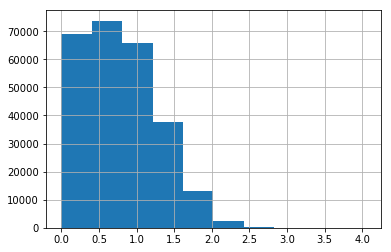

In [309]:
np.log10(1+d1.LIKES_COUNT).hist()

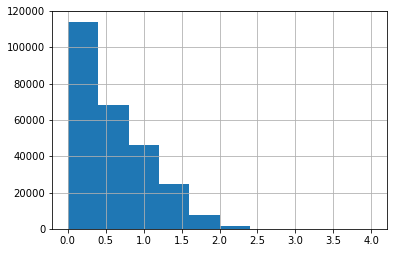

In [310]:
np.log10(1+d1.DISLIKES_COUNT).hist()

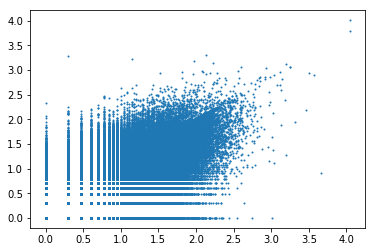

In [312]:
plt.scatter(np.log10(1+d1.LIKES_COUNT), np.log10(1+d1.DISLIKES_COUNT), s = 1)

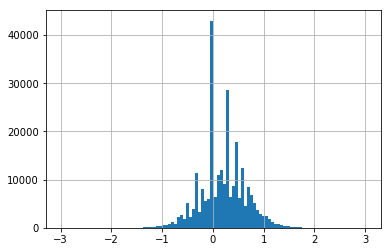

In [314]:
likeness = np.log10(1+d1.LIKES_COUNT)- np.log10(1+d1.DISLIKES_COUNT)
likeness.hist(bins=100)

Пытаемся предсказать, насколько рейтинг понравится людям. 

Понимаем, что топ признаков в получившейся модели - бессмысленные. Видим, что, кажется, люди не очень любят критику, но и только. 

In [324]:
y = likeness.fillna(0)
x = d1['total_text_prepared']
print(x.shape, y.shape)

(270941,) (270941,)


In [320]:
from sklearn.model_selection import cross_val_score, cross_val_predict, TimeSeriesSplit, KFold
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import r2_score

In [340]:
pipe_tf = TfidfVectorizer(min_df=10, ngram_range=[1,2]).fit(x)
pipe_x = pipe_tf.transform(x)
print(pipe_x.shape)

(270941, 204661)


In [341]:
#pipe = make_pipeline(TfidfVectorizer(min_df=3), Ridge(1))
cross_val_score(Ridge(10), pipe_x, y, cv= KFold(2, shuffle=True, random_state=1), n_jobs=-1)

array([ 0.09723266,  0.09403676])

In [351]:
reg = Ridge(10).fit(pipe_x, y)

In [353]:
inv_idx = {value:key for key, value in pipe_tf.vocabulary_.items()}
c = reg.coef_
best = [inv_idx[i] for i in np.argsort(c)[-20:]]
worst = [inv_idx[i] for i in np.argsort(c)[:20]]
print(', '.join(best))
print(', '.join(worst))

выше, тихо, haier, складный, читать, плеер, измельчать, _smile_positive, нетбук, единственный, отличный блендер, mkv, действительно, недостаток, не пожалеть, отзыв, комбайн, отличный, шедевр, блендер
мнение новинка, новинка, xiaomi, про acer, kitchenaid, не советовать, отзыв про, acer, не понравиться, трансформер, ужасный, ноутбук трансформер, разочарование, отстой, мнение, не стоить, разочаровать, redmi, 4a, 4к


А если предсказывать, какое внимание привлечёт отзыв? Это получается чуть лучше, но в целом тоже довольно плохо. 

Отзывы, где чего-то "не обнаружили" или "не выявили", не интересные. 

In [346]:
y0 = np.log10(1+d1.LIKES_COUNT + d1.DISLIKES_COUNT).fillna(0)

In [347]:
cross_val_score(Ridge(10), pipe_x, y0, cv= KFold(2, shuffle=True, random_state=1), n_jobs=-1)

array([ 0.15613324,  0.15704231])

In [348]:
reg = Ridge(10).fit(pipe_x, y0)

In [350]:
inv_idx = {value:key for key, value in pipe_tf.vocabulary_.items()}
c = reg.coef_
best = [inv_idx[i] for i in np.argsort(c)[-20:]]
worst = [inv_idx[i] for i in np.argsort(c)[:20]]
print(', '.join(best))
print(', '.join(worst))

psp, nokia, недостаток, оценка, айфон, блендер, борк, samsung, приставка, аппарат, телевизор, iphone, haier, bosch, apple, консоль, nbsp, новинка, отзыв, bork
нет, эксперт, не обнаружить, чехол, не найти, заряжать, прочный, обнаружить, 2017, не выявить, эксперт видео, год, выявить, подойти, салфетка, компактность, ответ эксперт, зуб, защищать, отзыв про


Вывод: предсказывать лайкабельность сложно, и, наверное, результаты не очень полезные. 

# Части речи в отзывах 

In [358]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [370]:
tag = morph.parse('защищать')[0].tag
print(tag)

INFN,impf,tran


In [ ]:
tag

In [379]:
import re

In [380]:
re.split('\W+', 'Words, words, words.')

['Words', 'words', 'words', '']

In [136]:
sample = text_by_product.sample(1)
text = sample['total_text'].values[0]
print(text)


***
Глючное железо, имеется несколько моделей. У всех проблемы с сетью и HDD.
Сервисная поддержка ASUS ужасна!
***
Производительный
***
Очень плохая реализация по железу. При нагреве много ошибок
*******

***
Драйвера на видеокарту конфликтуют с системой. В процессе работы или просмтра видео может перезагрузитья, либо вообще зависнуть Пришлось их удалить, после чего игровой ноутбук стал бюджетным. И помочь удаленно не могут, только в сервис. В плюсе только Сабвуфер, звук норм. 
***
САБВУФЕР
***
Видеокарта
*******

***
По заявленным характеристикам и соотношения цена ему нет равных, купил год назад, в результате поменяли 2 бука после постоянных зависаний видеокарты и тормозов жесткого диска, не третьем обмене просто плюнул на  эту модель вместе с asus. Третий бук работает, но переодически появляются артефакты и глюки на экране при серфинге интерактивных страниц. 
***
Хорошая батарея, дизайн корпус металл, средняя толщина, хороший full HD экран
***
нет подсветки клавиатуры, постоянные л

разбиение на подпредложения:
* справа и слева есть глагол (не инфинитив) [и существительное / местоимение] (сущ перед глаг), либо "существительное прилагательное"
* большая буква
* скобки
* разделители:
    * и
    * так как, то что, 
    * " - ", ":"
* выкинуть все вводные конструкции

In [540]:
def split_reviews(text):
    """ Takes one joint review and splits it into 
    """
    sents = [c.strip() for c in re.split('[\n\*,\.\!\(\)]', text) if len(c) > 3]
    ans = []
    for sent in sents:
        ans.append(sent)
        if len(sent) > 40:
            for d in ')', '(', ';', '-', ':':
                if d in sent:
                    for c in sent.split(d):
                        if len(c) > 3:
                            ans.append(c)
            for d in ['и', 'хотя', 'но', 'a']:
                d = ' '+d+' '
                if d in sent:
                    for c in sent.split(d):
                        if len(c) > 3:
                            ans.append(c)
    return ans

In [279]:
def split_into_words(text):
    words =  re.sub('[^a-zA-Zа-яА-Я]+', ' ', text).split()
    return [w for w in words if len(w)>3]

In [541]:
sents = split_reviews(text)
#sents

Цель - попробовать сгруппировать похожие предложения

In [170]:
from num2t4ru import num2text
num2text(100500)

'сто тысяч пятьсот'

In [171]:
from num2t4ru import num2text

# set('0123456789')
# todo: strip small letters from numbers, like 5-и, 5м

def insert_numbers(words):
    ans = []
    for word in words:
        if word.isdigit():
            ans = ans + util.tokenize(num2text(int(word)))
        else:
            ans.append(word)
    return ans
print(insert_numbers(util.tokenize('5 метровый кабель')))

['пять', 'метровый', 'кабель']


In [172]:
def space_after_digits(word):
    digits = set('0123456789')
    ans = ''
    prev_is_digit = False
    for letter in word:
        is_digit = (letter in digits)
        if prev_is_digit and not is_digit:
            ans = ans + ' '
        ans = ans + letter
        prev_is_digit = is_digit
    return ans
space_after_digits('5-и метровый кабель')

'5 -и метровый кабель'

In [173]:
def replace_punct(word):
    for symbol in r'-/:;':
        word = word.replace(symbol, ' ')
    return word

In [174]:
def longest(words):
    """ Returns the longest word
    """
    if ' ' not in words:
        return words
    words = words.split()
    l = 0
    ans = ''
    for word in words:
        l0 = len(word)
        if l0 > l:
            l = l0
            ans = word
    return ans
print(max_part('какбы'), max_part('как бы'))

какбы как


In [691]:
# todo: веса, обратно пропорциональные частотности

vocab = set(w2v.index2word)

from hunspell import Hunspell
h =  Hunspell("Russian-English Bilingual", hunspell_data_dir = r'C:\Users\ddale\Downloads\mv\CyHunspell-1.2.0\dictionaries')

def sent2words(sent):
    return util.lemmatize(insert_numbers(util.tokenize(space_after_digits(replace_punct(sent)))))

def sent2vec(words, verbose = False):
    """ Turns sentence into a vector
        Requires an instance of w2v gensim model and an instance of total_counter
    """
    #print(words)
    total = np.zeros(w2v.syn0.shape[1])
    weights = 1e-4
    for word in words:
        word = word.replace('ё', 'е').strip()
        if word not in vocab:
            if verbose:
                print(word, 'not in vocab', end = ' ')
            suggestions = []
            try:
                suggestions = [longest(c) for c in h.suggest(word)]
            except MemoryError:
                pass
                # continue silently
            suggestions = [c for c in suggestions if c in vocab]
            if verbose:
                    print(suggestions)
            if suggestions:
                word = suggestions[0]
        if word in vocab:
            v = w2v.word_vec(word)
            # часто глобально встречающиеся слова мы взвешиваем вниз
            w = 1 #/ np.sqrt(1+total_df[word])
            total = total + v
            weights = weights + w
        else:
            pass
    ans = total / weights
    return ans / np.sqrt(sum(ans**2)+1e-4)

In [255]:
vecs = [sent2vec(sent, verbose = False) for sent in sents]
vecmat = pd.DataFrame(vecs).fillna(0)
vecmat.shape

(465, 100)

In [256]:
mat = vecmat.transpose().corr()
mat.shape

(465, 465)

In [322]:
def get_trigrams(lemmas):
    return [w1+'_'+w2+'_'+w3 for w1, w2, w3 in zip(lemmas[:-2], lemmas[1:-1], lemmas[2:])]

In [754]:
from sklearn.cluster import DBSCAN, MeanShift, KMeans

rs = '\n*******\n'

def bt(review):
    seq = util.tokenize(space_after_digits(replace_punct(re.sub('[^a-zA-Zа-яА-Яё]+', ' ', review))))
    arr = util.get_bigrams(seq) + get_trigrams(seq)
    return [a.replace('_', ' ') for a in arr]

def extract_facts(joined_reviews, verbose = False, eps = 0.3, grams = False, censor = True):
    # split big review into different reviews and those into facts
    reviews = joined_reviews.split(rs)
    
    if grams:
        sents2_raw = [bt(review)  for review in reviews]
    else:
        sents2_raw = [split_reviews(review)  for review in reviews] # + bt(review)
    sents2 = [[sent2words(r) for r in review] for review in sents2_raw]
    #print(len(sents2_raw), len(sents2))
    #seqs = [util.lemmatize(split_into_words(review)) for review in reviews]
    #sents2 = [util.get_bigrams(seq) + get_trigrams(seq) for seq in seqs]
    #sents2 = [[sent.split('_') for sent in sents] for sents in sents2 ]
    
    
    sents_flat = [sent for sents in sents2 for sent in sents]
    id2doc = [i for i, sents in enumerate(sents2) for sent in sents]
    vecs = [sent2vec(sent) for sents in sents2 for sent in sents]
    
    #print(sents_flat)
    #print([' '.join(s) for s in sents_flat])
    
    vecmat = pd.DataFrame(vecs).fillna(0)
    clu = DBSCAN(min_samples=2, eps=eps, p=2)
    #clu = MeanShift(bandwidth=eps)
    #clu = KMeans(n_clusters=5)
    result = clu.fit_predict(vecmat)
    if verbose:
        print(result)
    s2 = pd.Series(sents_flat)
    who2 = pd.Series(id2doc)
    
    sents_raw_flat = pd.Series([sent for sents in sents2_raw for sent in sents])
    
    candidates = dict()
    representatives = dict()
    
    for ur in np.unique(result[result>=0]):
        fltr = result==ur
        if sum(fltr) == 1 or sum(fltr) > 30:
            # too small or too large a cluster
            continue
        if who2[fltr].std() < 1e-5 and censor:
            # only one source
            continue
        if verbose:
            print()
            print(sum(fltr), who2[fltr].var())
        candidates[ur] = 0
        min_dist = np.inf
        representative = 'ERROR'
        center = vecmat[fltr].mean()
        for sent, vec, raw in zip(s2[fltr], vecmat[fltr], sents_raw_flat[fltr]):
            if verbose:
                print('\t', ' '.join(sent).strip())
            # accumulate total tf-idf
            cand_weight = sum([1 / np.log(1.01 + total_counter[word]) * (total_df[word]>1) * len(word)  for word in sent])
            candidates[ur] += cand_weight
            dist = sum((center - vec)**2)*0.5 / cand_weight
            if dist < min_dist:
                min_dist = dist
                representative = raw
        representatives[ur] = representative
        
    result = pd.concat([pd.Series(representatives), pd.Series(candidates)], axis = 1)
    result.columns = ['center', 'importance']
    result.sort_values('importance', ascending = False, inplace = True)
    return result

In [708]:
sample = text_by_product.sample(1)

In [709]:
text = sample['total_text'].values[0]
#print(text)
print(len(text))
extract_facts(text, True, 0.4).values

3707
[[], ['СУПЕР ТЕЛЕФОН'], ['хорошей смартфон', 'красивый', 'царапается'], ['Служит мне уже полтора года', 'телефон замечательный', 'при ежедневном активном использовании нисколько не просел по производительности - система работает так же как и при покупке быстро и без глюков', 'при ежедневном активном использовании нисколько не просел по производительности ', ' система работает так же как и при покупке быстро и без глюков', 'при ежедневном активном использовании нисколько не просел по производительности - система работает так же как', 'при покупке быстро', 'без глюков', 'Фотокамеры неплохие', 'Чехлы на алиэкспресс можно заказать', 'их куча', 'Но огромный минус - это батарея', 'Разряжается он быстро', 'Ну конечно если вы часами не смотрите сериалы и тд то этот телефон самое то', 'Ну конечно если вы часами не смотрите сериалы', 'тд то этот телефон самое то'], ['Очень солидный аппарат на пятом андроиде', 'взял сразу два таких - себе и жене', 'удобно', 'что можно одновременно две симки 

array([['телефон замечательный', 3.5237989213570446],
       ['КАМЕРА', 1.1946669747901917]], dtype=object)

In [694]:
print(text)

Хороший телефон
***
Купил этот телефон в М.Видео еще в ноябре в интернет магазине. Аппаратом в целом доволен. 
1) Отличный экран
2) Качественная сборка
3) Качественные материалы изготовления (металл, стекло)
4) Отличная визуализация интерфейса операционной системы, превосходный мультитач
5) Потрясающая фотокамера
6) Быстрая скорость работы за счёт шустрого процессора, отсутствие зависаний
***

***

*******
Apple iPhone4
***
Приобрела это чудо!!!
И довольна им!
Больше всего понравилась быстрая скорость за счёт шустрого процессора,не зависает.Один минус долго вникала что к чему)
***

***

*******
Отстой полный...
***
Далеко не стоит своей цены. Экран LCD очень стар по сегодняшним меркам. ОС закрытого типа не дает ничего сделать, ни по блютузу музыку и фотки перекинуть, ни посмотреть фильм в нормальном формате, к примеру MKV. А чего стоит iTunes... Это просто хлам.
***

***

*******
Отличный телефон
***
Так как обожаю технику Apple приобрела данный телефон.
Обожаю его. Отличный дизайн, хо

# new data

In [6]:
d_new = pd.read_csv('proba_1_v5.csv', index_col=0)
print(d_new.shape)
d_new.head(3)

(1539, 16)


,PRODUCT,NAME,CATEGORY_ID,BRAND_ID,CATEGORY_NAME,BRAND_NAME,TYPE,SUBJECT,TEXT,POSTED_DATE,RATING,BENEFITS,DRAWBACKS,RECOMMENDED,LIKES_COUNT,DISLIKES_COUNT
0,20025017,Морозильная камера Liebherr G 1213-20 ...,4020301,313,FREEZERS,Liebherr,review,NaN,"Небольшая симпатичная морозильная камера, нашл...",02.09.2013,4.0,NaN,NaN,0,30,26
1,20025017,Морозильная камера Liebherr G 1213-20 ...,4020301,313,FREEZERS,Liebherr,review,NaN,Пользуемся месяц. Искали недорогую маленькую м...,17.09.2017,5.0,низкая цена по сравнению с другими с такими же...,Пока не нашла,0,1,0
2,20025017,Морозильная камера Liebherr G 1213-20 ...,4020301,313,FREEZERS,Liebherr,review,NaN,"Морозилка хорошая, подошла по высоте кухонного...",25.08.2017,4.7,NaN,NaN,0,1,0


In [11]:
def apply_to_new_data(d1):
    ps = '\n***\n'
    d1['total_text'] = (d1['SUBJECT'].fillna('') + ps + d1['TEXT'].fillna('') + ps + d1['BENEFITS'].fillna('') 
                        + ps + d1['DRAWBACKS'].fillna(''))
    text_by_product = d1[['total_text']].groupby(d1['NAME']).aggregate(lambda x : rs.join(x))
    ans = dict()
    for key, value in text_by_product.iterrows():
        facts = extract_facts(value.values[0], True, 0.4).center
        if len(facts) == 0:
            facts = extract_facts(value.values[0], True, 0.4, False, False).center
        if len(facts) == 0:
            facts = extract_facts(value.values[0], True, 0.4, True, False).center
        val = '\n > '.join(['Пользователи пишут:']+list(facts.apply(lambda x: x.capitalize())))
        ans[key] = val
    return ans

In [12]:
tmp = apply_to_new_data(d_new)
print(tmp)

NameError: name 'extract_facts' is not defined

In [796]:
for k, v in tmp.items():
    print(k)
    print(v)

Морозильная камера Liebherr G 1213-20                                
Пользователи пишут:
 > Хотя выставили по уровню и сняли держатель для шнура
 > Внешний вид
 > Несмотря на маленький размер морозильной камеры ящики в ней очень вместительные
 > Ящики удобные и вместительные
 > Нашла в интернет-магазине
 > Покупкой доволен
 > Кондиционер в сравнение с морозилкой более шумный
 > Приобретением довольны и желаем всем удачной покупки
 > Позволяющие покупать хорошую технику по доступным ценам
 > Морозильную камеру купили в начале августа
 > Вместительная
 > 4 года назад началась моя любовь с либхером с такой камеры
 > Разместил в коридоре - вписалась идеально
 > Пока не нашла
 > С прочными выдвижными ящиками для хранения
 > Быстро замораживает овощи и ягоды
 > Купили почти год назад
 > Работает бесшумно
 > Вместительная и небольшая по габаритам
 > Стильная и компактная морозильная камера
 > Хотя выставили по уровню
 > Морозилка хорошая
 > Рекомендую
 > Хорошо морозит
 > Уровень шума оценю 

 > Цена
Пылесос с пылесборником Bosch GL-30 BGL32003                         
Пользователи пишут:
 > Есть индикатор заполнения мешка для сбора пыли
 > Покупкой довольна
 > Длинный шнур
 > Хорошо всасывающий - это при мощности всасывания 300 вт
 > Очень мощный пылесос
 > Нет в комплекте сменных мешков
 > Хорошо всасывает
 > Отличный пылесос
 > Мощный
 > Только хорошие впечатления
 > В использовании уже 3 года
 > Отлично втягивает мусор
 > Мощность  хорошая
 > А сменный мешок вытащил и выбросил
 > Пылесборник не многоразовый
 > Хорошо пылесосит
 > Убираться с ним одно удовольствие
 > Купили маме в подарок
 > Легкий
 > Закрывается крышка еще более хлипкой защелкой
 > Регулировка мощности
 > Пылесос очень понравился
 > Купили пылесос пол года назад
 > Качество щетки могло бы быть посолиднее для боша
 > Рекомендую: соотношение - качество-цена
 > Отлично справляется со своей работой
 > Надеемся прослужит долго
 > В общем отличный агрегат за свои деньги
 > Немного хлюпкий корпус
 > Регулируем

 > 16 лет
Стиральная машина Узкая Haier HW60-1211N                             
Пользователи пишут:
 > Мне нужна была модель со съемной крышкой под столешницу
 > Нет регулировки отжима
 > Возможность встроить в кухню и регулировка температуры стирки- очень удобная вещь
 > Приехал мастер установил и начал проверять при пробном пуске потекла вода снизу машинки
 > При отжимание 1200 оборотов немного шумновата :-
 > При узкой ширине очень вместительная и тихая при больших оборотах отжима
 > На днях купили холодильник данной фирмы
 > 9 квт/ч это соответствует классу энергоэфективности а
 > Заусенцы и острые задиры на кромке барабана
 > Насчет антибактериальной резинки и лотка это такая уловка производителя
 > Стремаюсь кого-то залить невзначай
 > Работает тихо
 > Что люди приувеличивают
 > Чудная стиральная машина с удобным расположение кнопок
 > Очень понравились функции дополнительного полоскания и интенсивной стирки
 > Эта машинка класса энергоэфективности а
 > Мы пошли домой переспать с

 > Error
Стиральная машина Узкая Samsung WW65K52E69S                          
Пользователи пишут:
 > По сравнению с другой моделью- как небо и земля
 > Не вымывает порошок из отсека для него
 > Много нужных функций нет лишьних пользуюсь почти всеми
 > По сравнению  со старой индезит
 > На сторой у нас все программы были по 30
 > Красивый дизайн
 > Порошок полностью не вымывает
 > Возможность дозагрузки белья
 > Хорошее качество стирки
 > Отлично стирает
 > Дозагрузка
 > Не нашел
 > Прослужить много времени
 > Внешний вид высший
 > Машинку только купили
 > Очень довольны
 > В пользовании третий месяц
 > Очень рад и красивый и функциональный
 > Тихая
 > Рекомендую
 > Бесшумная
 > Стирает очень тихо
 > Рекомендую всем
 > Такие как носок
 > Что забыл положить
 > Машинка очень тихая
 > Дизайн
 > Все отлично
 > Эксперт месяца
 > Красивая
 > Функционал
 > Очень удобно
 > В общем
 > Знаю
 > На 3
Телевизор Haier LE24B8000T                                           
Пользователи пишут:
 > По го

 > Error
Холодильник с нижней морозильной камерой Hotpoint-Ariston HFP 7200 XO
Пользователи пишут:
 > Что не надо раз в месяц все запасы подъедать и вываливать все завалявшееся с последующим отключением электричества
 > Система очистки воздуха
 > Внешний вид
 > Цена


In [798]:
tmp2 = {k: '\n'.join(v.split('\n')[0:6]) for k, v in tmp.items()}
print(tmp2)

{'Морозильная камера Liebherr G 1213-20                                ': 'Пользователи пишут:\n > Хотя выставили по уровню и сняли держатель для шнура\n > Внешний вид\n > Несмотря на маленький размер морозильной камеры ящики в ней очень вместительные\n > Ящики удобные и вместительные\n > Нашла в интернет-магазине', 'Ноутбук ASUS X541UV-XO241T                                           ': 'Пользователи пишут:\n > World of tanks тянет на средних настройках 40-50 fps\n > Проблем благодаря опыту пользования windows 10 в течение пары лет не было\n > Через 3 недели полетел жесткий диск\n > Сильно не греется и не шумит\n > Что ноутбук относительно лёгкий и тонкий', 'Ноутбук Apple MacBook Pro 13 i5 2.3/8/128Gb SG (MPXQ2RU/A)           ': 'Пользователи пишут:\n > Как оказалось новые порты очень даже удобные', 'Ноутбук Apple MacBook Pro 13\\" Early 2015 MF839RU/A                  ': 'Пользователи пишут:\n > Вместо imac retina+macbook retina 12 берем описываемый macbook pro 13 и наслаждаемся\n > 

In [799]:
for k, v in tmp2.items():
    print(k)
    print(v)

Морозильная камера Liebherr G 1213-20                                
Пользователи пишут:
 > Хотя выставили по уровню и сняли держатель для шнура
 > Внешний вид
 > Несмотря на маленький размер морозильной камеры ящики в ней очень вместительные
 > Ящики удобные и вместительные
 > Нашла в интернет-магазине
Ноутбук ASUS X541UV-XO241T                                           
Пользователи пишут:
 > World of tanks тянет на средних настройках 40-50 fps
 > Проблем благодаря опыту пользования windows 10 в течение пары лет не было
 > Через 3 недели полетел жесткий диск
 > Сильно не греется и не шумит
 > Что ноутбук относительно лёгкий и тонкий
Ноутбук Apple MacBook Pro 13 i5 2.3/8/128Gb SG (MPXQ2RU/A)           
Пользователи пишут:
 > Как оказалось новые порты очень даже удобные
Ноутбук Apple MacBook Pro 13\" Early 2015 MF839RU/A                  
Пользователи пишут:
 > Вместо imac retina+macbook retina 12 берем описываемый macbook pro 13 и наслаждаемся
 > Твердотельный накопитель данного комп

ОБъединяем два результата

In [800]:
with open('25_2_dataframes', 'rb') as file:
    valera = pickle.load(file)

UnicodeDecodeError: 'ascii' codec can't decode byte 0xd0 in position 26: ordinal not in range(128)

In [803]:
pd.Series(tmp2).to_csv('synentic.csv', sep = ';')

In [801]:
pickle.dump(tmp2, open('syntetic.pkl', 'wb'))

In [802]:
pickle.load(open('syntetic.pkl', 'rb'))

{'Морозильная камера Liebherr G 1213-20                                ': 'Пользователи пишут:\n > Хотя выставили по уровню и сняли держатель для шнура\n > Внешний вид\n > Несмотря на маленький размер морозильной камеры ящики в ней очень вместительные\n > Ящики удобные и вместительные\n > Нашла в интернет-магазине',
 'Ноутбук ASUS X541UV-XO241T                                           ': 'Пользователи пишут:\n > World of tanks тянет на средних настройках 40-50 fps\n > Проблем благодаря опыту пользования windows 10 в течение пары лет не было\n > Через 3 недели полетел жесткий диск\n > Сильно не греется и не шумит\n > Что ноутбук относительно лёгкий и тонкий',
 'Ноутбук Apple MacBook Pro 13 i5 2.3/8/128Gb SG (MPXQ2RU/A)           ': 'Пользователи пишут:\n > Как оказалось новые порты очень даже удобные',
 'Ноутбук Apple MacBook Pro 13\\" Early 2015 MF839RU/A                  ': 'Пользователи пишут:\n > Вместо imac retina+macbook retina 12 берем описываемый macbook pro 13 и наслаждаемся\n

In [805]:
d_new[d_new.NAME=='Телевизор Haier LE24B8000T']

,PRODUCT,NAME,CATEGORY_ID,BRAND_ID,CATEGORY_NAME,BRAND_NAME,TYPE,SUBJECT,TEXT,POSTED_DATE,RATING,BENEFITS,DRAWBACKS,RECOMMENDED,LIKES_COUNT,DISLIKES_COUNT,total_text


In [807]:
dict(set(zip(d_new.PRODUCT, d_new.NAME)))

{10006402: 'Телевизор Samsung UE22H5610AK                                        ',
 10008332: 'Телевизор Haier LE24B8000T                                           ',
 10010083: 'Телевизор LG 43LH595V                                                ',
 10012105: 'Телевизор Sony KD49XE8077                                            ',
 20025017: 'Морозильная камера Liebherr G 1213-20                                ',
 20027607: 'Холодильник с нижней морозильной камерой Beko CMV 529221 W           ',
 20029099: 'Стиральная машина Узкая AEG AMS7000U                                 ',
 20029414: 'Пылесос ручной (handstick) Bosch BCH6ATH25K                          ',
 20029680: 'Посудомоечная машина (45 см) Bosch Aqua Stop SPS40X92RU              ',
 20030060: 'Пылесос с пылесборником Bosch GL-30 BGL32003                         ',
 20035772: 'Стиральная машина Узкая Haier HW60-1211N                             ',
 20036154: 'Холодильник с нижней морозильной камерой Haier C2F637CFMV       

In [808]:
d_new[d_new.PRODUCT==10008332]

,PRODUCT,NAME,CATEGORY_ID,BRAND_ID,CATEGORY_NAME,BRAND_NAME,TYPE,SUBJECT,TEXT,POSTED_DATE,RATING,BENEFITS,DRAWBACKS,RECOMMENDED,LIKES_COUNT,DISLIKES_COUNT,total_text
1143,10008332,Телевизор Haier LE24B8000T ...,1070907,1687,"LED TV 15\""-30\""",Haier,review,NaN,Приобрёл небольшой телевизор для кухни Haier L...,28.07.2016,5.0,NaN,NaN,0,48,27,\n***\nПриобрёл небольшой телевизор для кухни ...
1144,10008332,Телевизор Haier LE24B8000T ...,1070907,1687,"LED TV 15\""-30\""",Haier,review,NaN,при самовывозе промокод на 500 рублей не вручи...,09.09.2017,4.0,Приятная картинка звук тоже норм не дорогой,пять раз делал поиск цифровые каналы а 2-х та...,0,0,1,\n***\nпри самовывозе промокод на 500 рублей н...
1145,10008332,Телевизор Haier LE24B8000T ...,1070907,1687,"LED TV 15\""-30\""",Haier,review,NaN,Купил телевизор по акции Обыкновенный телеви...,26.08.2017,4.0,NaN,NaN,0,0,0,\n***\nКупил телевизор по акции Обыкновенный...
1146,10008332,Телевизор Haier LE24B8000T ...,1070907,1687,"LED TV 15\""-30\""",Haier,review,NaN,"Приобрел такой телевизор,через месяцев семь пе...",27.07.2017,3.0,NaN,NaN,0,1,0,"\n***\nПриобрел такой телевизор,через месяцев ..."
1147,10008332,Телевизор Haier LE24B8000T ...,1070907,1687,"LED TV 15\""-30\""",Haier,review,NaN,"Используем ещё меньше месяца, но приятно радуе...",29.06.2017,5.0,"Компактный, четкое изображение",Пока не нашла,0,0,1,"\n***\nИспользуем ещё меньше месяца, но приятн..."
1148,10008332,Телевизор Haier LE24B8000T ...,1070907,1687,"LED TV 15\""-30\""",Haier,review,NaN,"нормальный тв за эти деньги,звук неважный,6вт,...",06.02.2017,4.7,"нормальная картинка,удобная настройка,вменяемо...","звук на троечку,",0,3,0,"\n***\nнормальный тв за эти деньги,звук неважн..."
1149,10008332,Телевизор Haier LE24B8000T ...,1070907,1687,"LED TV 15\""-30\""",Haier,review,NaN,Хорошее качество изображения и большие углы об...,30.10.2016,5.0,NaN,NaN,0,2,1,\n***\nХорошее качество изображения и большие ...
1150,10008332,Телевизор Haier LE24B8000T ...,1070907,1687,"LED TV 15\""-30\""",Haier,review,NaN,Изначально планировал взять что-либо из раскру...,18.10.2016,5.0,"Современный дизайн,оч хорошие цвета,простое по...",На пульте кнопки можно было сделать потолще.,0,2,0,\n***\nИзначально планировал взять что-либо из...
1151,10008332,Телевизор Haier LE24B8000T ...,1070907,1687,"LED TV 15\""-30\""",Haier,review,NaN,почему то когда подсоединяешь через пальчиковы...,02.09.2016,4.0,NaN,NaN,0,1,0,\n***\nпочему то когда подсоединяешь через пал...
1152,10008332,Телевизор Haier LE24B8000T ...,1070907,1687,"LED TV 15\""-30\""",Haier,review,NaN,"Взяли 2 месяца назад, нареканий по работе нет....",08.08.2016,4.0,NaN,NaN,0,2,0,"\n***\nВзяли 2 месяца назад, нареканий по рабо..."


In [810]:
text_by_product.index

Int64Index([  500677,   500678,   500679,   500787,   500944,   500983,
              501033,   501034,   808023,   808024,
            ...
            50049740, 50049741, 50049742, 50049743, 50049810, 50049816,
            50049842, 50049862, 50049863, 50049912],
           dtype='int64', name='PRODUCT', length=36475)

In [811]:
def get_dext_by_prod(d1):
    d1['total_text'] = (d1['SUBJECT'].fillna('') + ps + d1['TEXT'].fillna('') + ps + d1['BENEFITS'].fillna('') 
                        + ps + d1['DRAWBACKS'].fillna(''))
    text_by_product = d1[['total_text']].groupby(d1['NAME']).aggregate(lambda x : rs.join(x))
    return text_by_product

In [812]:
p2t = get_dext_by_prod(d_new)

In [818]:
print(p2t.iloc[-7].values[0])


***
Приобрёл небольшой телевизор для кухни Haier LE24B8000T, по акции вышел 8990р. Долго думал какую выбрать модель LE24B8000T (наличие встроенного ресивера DVBT2, но экран HD Ready) или LE24B8000F (расширение дисплея Full HD, но отсутствует тюнер DVBT2), остановился на первом варианте, ловит 20 цифровых каналов на уличную антенну, картинка отличная. Покупкой доволен.
***

***

*******

***
при самовывозе промокод на 500 рублей не вручили !
***
Приятная картинка звук тоже норм не дорогой
***
пять раз делал поиск цифровые  каналы а 2-х так и не хватает и главное в списке их не 2-ой и 7-ой вроде ! это ни есть хорошо ,по гуглил ни чего не нашёл и не знаю как и быть
*******

***
Купил телевизор по акции   Обыкновенный телевизор  Особых минусов пока не обнаружил,разве что долго переключаются каналы и кнопки у пульта очень громко щелкают  Если в акции - то брать можно,но за полную цену этот телевизор не стоит
***

***

*******

***
Приобрел такой телевизор,через месяцев семь перестал включа